# MASTER FUNCTION
The master function contains all the modules to build a simulation. All of the parameters are pre set for you and change them as you see fit. Below is the function and it's parameters and respective data types.

```python
def master_function(demand=demand,
                    Date='2018-06-11',
                    percentOfPassenger=.309, 
                    percentDropOff=.5,
                    percentPickUp=.5,
                    percentOfTNC=.255,
                    percentOfTaxi=.027,
                    percentOfTransit=.005,
                    percentOfParking=.25,
                    percentOfLimo=.01,
                    percentOfRental=.144,
                    dwell_times=dwell_time,
                    scale = 1,
                    sigma=.5 ):
```

In [53]:
from __future__ import print_function
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element, SubElement, Comment
from lxml import etree
from copy import copy
import os
import inspect
from xml.dom import minidom
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import datetime
sys.path.insert(0, os.path.abspath('../Generate_SUMO_demand/'))
import DFW_gen_flow as gf
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import ToggleButtons
import math 

import nbimporter
from Split_Arrive_Depart_And_Cars_To_People import cars_to_people, distributeParking, create_depart_arrive
from Select_Day import pick_day 
from Generate_Taxi_Trips import create_sumo_demand_taxi_curbside
from Generate_Passenger_Trips import create_sumo_demand_passenger_curbside
from Generate_TNC_Trips import create_sumo_demand_TNC_curbside
from Generate_Limo_Trips import create_sumo_demand_limo_curbside
from Generate_PassThru_Trips import create_sumo_demand_passthru
from Generate_Parking_Trips import create_sumo_demand_parking
from Combine_XML_Trips import combineTrips

import warnings
warnings.filterwarnings('ignore')


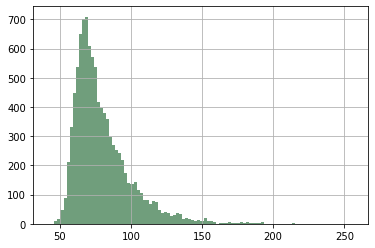

In [54]:
dwell_time = np.random.exponential(20,10000) + np.random.normal(60,5,10000)
demand = pd.read_csv("../Example_Files/athena_sumo_v1.csv")
selected = pd.read_csv("selected_demand.csv",)
plt.hist(dwell_time,bins=100,color='#709e7c')
plt.grid()
plt.show()

In [55]:
selected

,Unnamed: 0,Date,Volume_Category
0,0,2017-10-16,high
1,1,2017-10-28,low
2,2,2017-10-17,medium
3,3,2017-11-22,high
4,4,2017-11-30,medium
5,5,2017-11-24,low
6,6,2017-12-21,high
7,7,2017-12-28,medium
8,8,2017-12-2,low
9,9,2018-1-2,high


In [58]:
def master_function(demand=demand,
                    Date='2018-06-11',
                    percentOfPassenger=.309, 
                    percentDropOff=.5,
                    percentPickUp=.5,
                    percentOfTNC=.255,
                    percentOfTaxi=.027,
                    percentOfTransit=.005,
                    percentOfParking=.25,
                    percentOfLimo=.01,
                    percentOfRental=.144,
                    dwell_times=dwell_time,
                    scale = 1,
                    #CarsToPeople add later
                    peopleToCars = 1.7,
                    level = 'high',
                    sigma=.5 #0 is perfect driver and 1 is max imperfection
                   ):
    total = percentOfPassenger + percentOfTNC + percentOfTaxi + percentOfTransit + percentOfParking + percentOfRental + percentOfLimo 
    message = "Mode choices do not sum to 1; Seems to add to " + str(total)
    
    assert total == 1, message
    assert percentDropOff + percentPickUp == 1, "Drop off and Pickup must add to 1"
    
    #1. Split Arrival and Departure
    
    distributeParking(demand,['A','B','C','D','E']) 
    cars = create_depart_arrive(demand,percentDropOff,percentPickUp)
    #2. Convert Vehicles to People
    
    people_demand = cars_to_people(cars,peopleToCars)

    
    #3. Generate Demand for each Mode of Travel
        #a. Passenger
    print("Generating Passenger  Demand")
    create_sumo_demand_passenger_curbside(people_demand,level)
        #b. Taxi
    print("Generating Taxi Demand")
    create_sumo_demand_taxi_curbside(people_demand,level)
        #c. TNC
    print("Generating TNC Demand")
    create_sumo_demand_TNC_curbside(people_demand,level)
        #d. Limo
    print("Generating Limo Demand")
    create_sumo_demand_limo_curbside(people_demand,level)
        #e. Parking
    print("Generating Parking Demand")
    buses = create_sumo_demand_parking(people_demand,level)
#     add something for buses
        #f. Pass thru
    print("Generating Pass-Thru Demand")
    create_sumo_demand_passthru(people_demand)
    #4. Combine XML Files
    file_name = Date + '.' + level +".trips.xml"
    combineTrips(file_name)
    #5. Move Files to Eagle
        #Note: currently using scp
    #6. Run on Eagle
        #Note: ensure you have Network, Route file, additional file/s
        #also generate some type of output
    #7. Analyis of Outputs
        #a. convert to csv
        

In [60]:
master_function()

In [ ]:
#     file_name = Date + '.' + level + ".people.csv"
#     people_demand.to_csv(os.path.join(folder,file_name))
    